## Robot Tracking via Particle Filter

Track a robot through a maze with a particle filter and visualise the results

In [1]:
%load_ext autoreload
%autoreload 1
%aimport particle.map
%aimport particle.filter

import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import particle.filter as fl
import particle.map as mp

### Inspect maze

Let's take a look at the landscape we'll be tracking the robot through

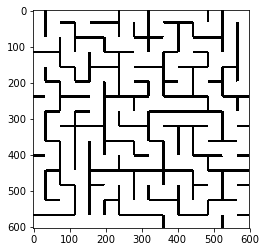

In [11]:
# load the map
le_map = mp.load_map('maze01.jpg')

# plotting
plt.imshow(le_map, cmap='Greys')
plt.show()

In [ ]:
# generate the route and get x,y position from it
state_history = fl.generate_route(le_map)
route = state_history[:, 1:3].astype('int')

# plotting
im = le_map.astype('float')
im[route[:, 0], route[:, 1]] = 0.5
plt.imshow(im, cmap='Greys')
plt.show()